# Prediction Model of Equipment in Smart Manufacturing for Predictive Maintenance

# I. Introduction

Objective:

This project objective is to do data analysis and create model Machine Learing (with 5 model and compare) to predict equipment in smart manufacturing for predictive maintenance.

Background:

In a manufacturing environment, the production process is crucial to meet market demand. One key factor in ensuring smooth production is the performance condition of equipment/machines. Smart manufacturing has enabled the collection of real-time operational data from machines via IoT-based systems to enable digital monitoring and ensure efficient processes. One major application of this data is in predictive maintenance strategy to anticipate equipment failures and perform maintenance before breakdowns occur. This helps avoid unexpected downtime, minimizes production halts, and ultimately reduces cost. If the maintannace can be predicted, it will help teams in manufacturing environment (Production, Maintenance and Enginnering teams) to achive production efficiency.

Problem Statment:

This project aims to build a Machine Learning classification model that can predict whether an equipment (under certain operational parameters and time) requires maintenance or not. The goal is to support maintenance and production scheduling with data-driven insights.  For equipment predicted to require maintenance, proactive actions can be scheduled by the maintenance team, coordinated with production, minimizing downtime. For equipment predicted to be healthy, the operational conditions can be studied and used as a benchmark for other machines. This predictive system reduces total maintenance costs and avoids production disruption.

URL Dataset : https://www.kaggle.com/datasets/ziya07/smart-manufacturing-iot-cloud-monitoring-dataset/data

Contents in Dataset:

- Timestamps – Time at which the sensor readings were recorded
- Machine ID – Unique identifier for each machine
- Sensor Readings – Temperature, Vibration, Humidity, Pressure, Energy Consumption
- Machine Status – Indicates whether the machine is Idle, Running, or in Failure (0, 1 or 2)
- Anomaly Flags – Identifies extreme values in temperature and vibration
- Predicted Remaining Life – Estimated time before maintenance is needed
- Failure Type – The reason for machine failure (Overheating, Vibration Issue and etc.)
- Downtime Risk Score – Probability of machine breakdown
- Maintenance Required (maintenance_required) – Target column (0 = No, 1 = Yes)

# II. Import Libraries

In [1]:
# Import Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from scipy.stats import kendalltau, chi2_contingency
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.metrics import classification_report, recall_score, f1_score
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# III. Data Loading

In [2]:
# Data loading

data = pd.read_csv('dataset.csv')
data

,timestamp,machine_id,temperature,vibration,humidity,pressure,energy_consumption,machine_status,anomaly_flag,predicted_remaining_life,failure_type,downtime_risk,maintenance_required
0,2025-01-01 00:00:00,39,78.61,28.65,79.96,3.73,2.16,1,0,106,Normal,0.0,0
1,2025-01-01 00:01:00,29,68.19,57.28,35.94,3.64,0.69,1,0,320,Normal,0.0,0
2,2025-01-01 00:02:00,15,98.94,50.20,72.06,1.00,2.49,1,1,19,Normal,1.0,1
3,2025-01-01 00:03:00,43,90.91,37.65,30.34,3.15,4.96,1,1,10,Normal,1.0,1
4,2025-01-01 00:04:00,8,72.32,40.69,56.71,2.68,0.63,2,0,65,Vibration Issue,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,2025-03-11 10:35:00,3,71.47,54.34,46.72,1.83,3.05,1,0,313,Normal,0.0,0
99996,2025-03-11 10:36:00,23,87.23,34.99,33.84,4.67,4.47,1,0,439,Normal,0.0,0
99997,2025-03-11 10:37:00,10,93.01,51.79,64.28,4.04,3.62,1,1,30,Normal,1.0,1
99998,2025-03-11 10:38:00,47,84.41,22.35,35.18,2.88,2.37,1,0,487,Normal,0.0,0


Dataset has 100000 datas/rows and 13 columns.

In [3]:
# Data info

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 13 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   timestamp                 100000 non-null  object 
 1   machine_id                100000 non-null  int64  
 2   temperature               100000 non-null  float64
 3   vibration                 100000 non-null  float64
 4   humidity                  100000 non-null  float64
 5   pressure                  100000 non-null  float64
 6   energy_consumption        100000 non-null  float64
 7   machine_status            100000 non-null  int64  
 8   anomaly_flag              100000 non-null  int64  
 9   predicted_remaining_life  100000 non-null  int64  
 10  failure_type              100000 non-null  object 
 11  downtime_risk             100000 non-null  float64
 12  maintenance_required      100000 non-null  int64  
dtypes: float64(6), int64(5), object(2)
memory usa

- `timestamp` is the identitiy column, this column will be droped during feature engineerig.
- `maintenance_required` will be the target column in modeling (0 = No, 1 = Yes)
- Numerical columns: `temperature`, `vibration`, `humidity`, `pressure`, `energy_consumption`, `predicted_remaining_life`,  `downtime_risk`
- Categorical columns: `machine_id`, `machine_status`, `anomaly_flag`, `failure_type`
- For data type that need to pay attention is for `timestamp` is supposed to be datetime type, but will be changed if needed. Also for categorical column `machine_id`, `machine_status` and `anomaly_flag` are int type data, they are already encoded and become numerical, further analysis will be conducted later.
- There is no null data in dataset.

In [4]:
# Data statistic summary

data.describe()

,machine_id,temperature,vibration,humidity,pressure,energy_consumption,machine_status,anomaly_flag,predicted_remaining_life,downtime_risk,maintenance_required
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,25.499330,75.015625,50.012270,54.995401,3.000405,2.747064,1.002050,0.089160,234.269160,0.089155,0.196970
std,14.389439,10.031884,14.985444,14.437960,1.152399,1.297865,0.446193,0.284976,150.063062,0.284961,0.397711
min,1.000000,35.550000,-17.090000,30.000000,1.000000,0.500000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,13.000000,68.267500,39.970000,42.520000,2.000000,1.630000,1.000000,0.000000,97.000000,0.000000,0.000000
50%,25.000000,75.060000,49.960000,54.980000,3.010000,2.740000,1.000000,0.000000,230.000000,0.000000,0.000000
75%,38.000000,81.750000,60.100000,67.500000,4.000000,3.870000,1.000000,0.000000,365.000000,0.000000,0.000000
max,50.000000,121.940000,113.800000,80.000000,5.000000,5.000000,2.000000,1.000000,499.000000,1.000000,1.000000


Overall the distribution seems good for numerical data, will analize more the ouliers in feature enginering.

In [5]:
# Checking duplicated data

data.duplicated().sum()

0

From the result which is 0, there is no duplicated data in dataset.

# IV. Exploratory Data Analysis

1. Distribution check for column target `maintenance_required`

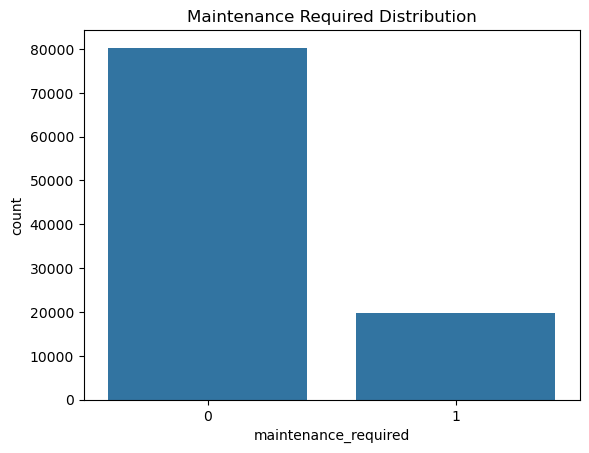

In [6]:
# Create bar plot

sns.countplot(x='maintenance_required', data=data)
plt.title('Maintenance Required Distribution')
plt.show()

From the bar plot, distribution for `maintenance_required` have big difference 0/no is around 80000 datas and 1/yes is around 20000 datas that makes this data is actually unbalanced.

2. Distribution check for column that data from sensor reading.

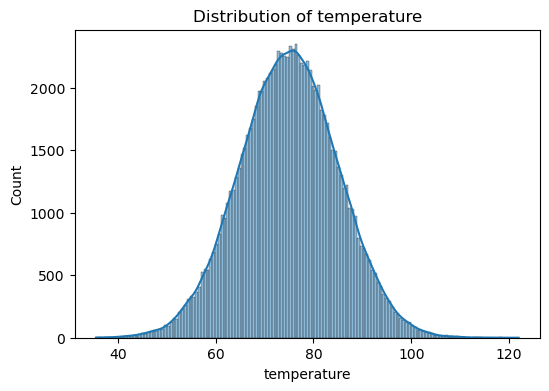

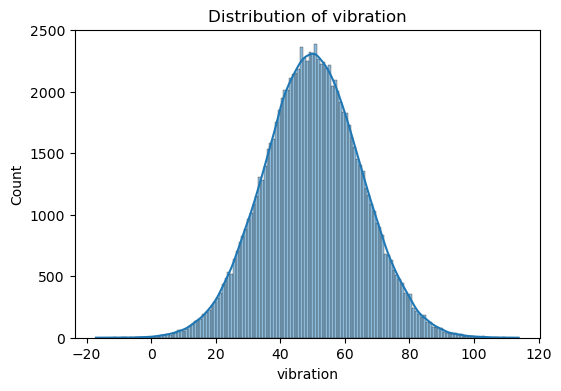

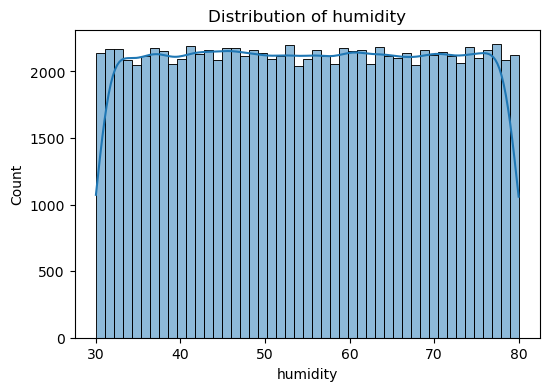

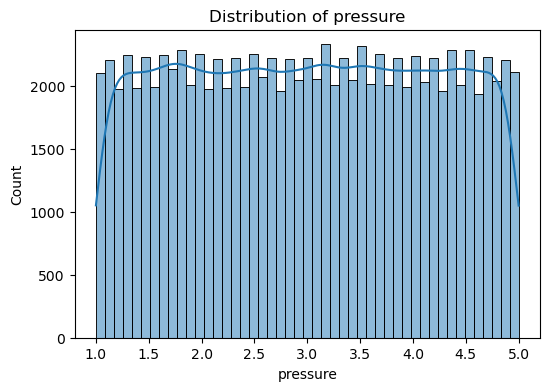

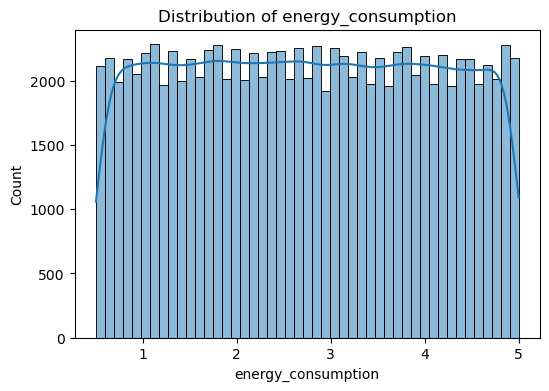

In [7]:
# Create plot for distribution

cols = ['temperature', 'vibration', 'humidity', 'pressure', 'energy_consumption']

for col in cols:
    plt.figure(figsize=(6, 4))
    sns.histplot(data[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()

- `temperature` has normal distibution with highest density around 75-80, which maybe the temperature condition of the equipment. There is tail in both side but not extreame, which means few outliers.
- `vibration` has normal distibution as well with highest density around 50, which maybe the normal average vibration condition of the equipment. There is tail in both side but not extreame, which means few outliers.
- `humidity` has uniform distribution, value spread fairly between 30 till 80. It means equipment work in very various humidity condition not in a certain pattern.
- `pressure` has uniform distribution also, value spread fairly between 1 till 5. It means equipment work in very various pressure condition not in a certain setting and not some parameters that need to control in exact condition like temperature.
- `energy_consumption` has uniform distribution as well, value spread fairly in the plot. It means equipment wor consume within that range. This distribution can be the case of study for energy saving by focusing energy_consumption at the low side as benchmark.

3. Distribution check for column numerical `predicted_remaining_life` and `downtime_risk`.

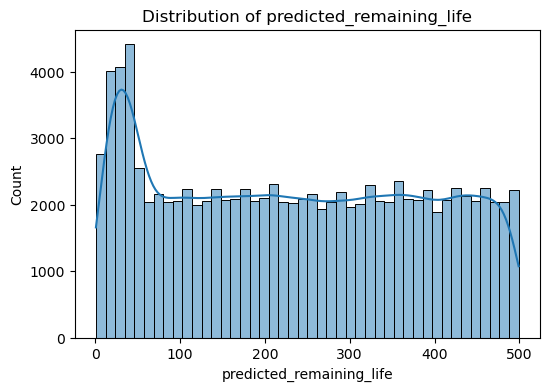

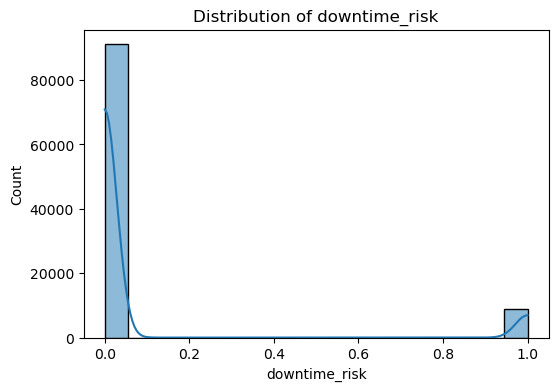

In [8]:
# Create plot for distribution

cols = ['predicted_remaining_life', 'downtime_risk']

for col in cols:
    plt.figure(figsize=(6, 4))
    sns.histplot(data[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()

- `predicted_remaining_life` has right skew but after the tail show uniform ditribution, it strat uniform after 100. So many equipment have short remianing life, indicating that most equipmnet are expected to need maintenance or replacement relatively soon, but after hunderd also not low and with uniform distribution till 500, also many equipment has more than 100 remaining life with range 100-500.
- `downtime_risk` column has highly right skewed, it is imbalanced as well, large concentartion at 0 and sharp spike near 1. It means most equipments are operating with low downtime risk score, but some with high socre is really critical.

4. Correlation numerical columns with `maintenance_required`.

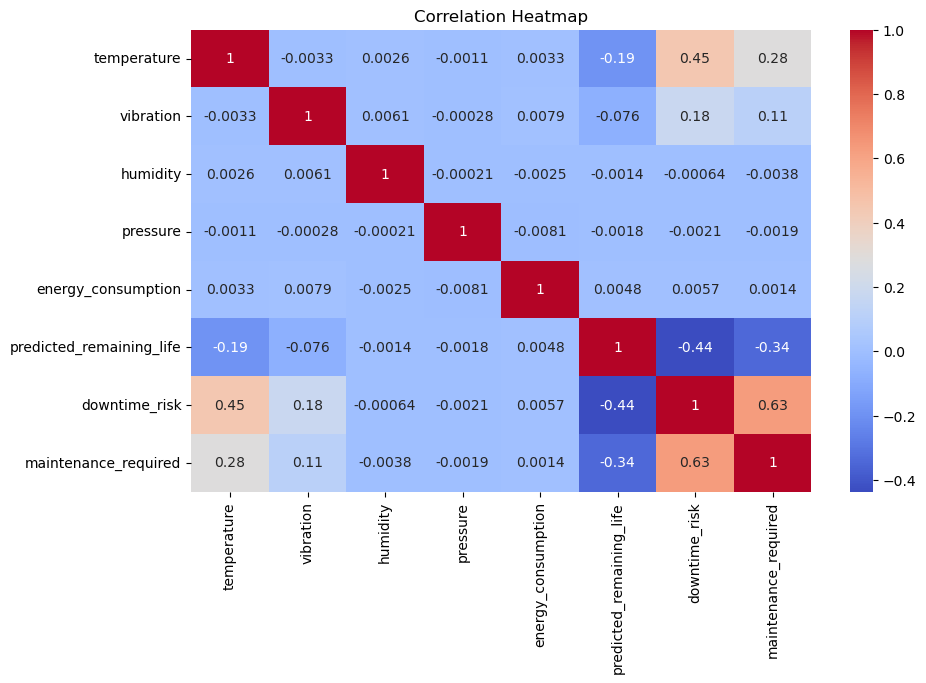

In [9]:
# Create heatmap for correlation

cols = ['temperature', 'vibration', 'humidity', 'pressure', 'energy_consumption', 'predicted_remaining_life', 'downtime_risk']

plt.figure(figsize=(10, 6))
sns.heatmap(data[cols + ['maintenance_required']].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

From Heatmap, the clear features that has correlation is `temperature` = 0.28, `vibration` = 0.11, `predicted_remaing_life` = -0.34 and `downtime_risk` = 0.63, because correlation value is more than 0.1 for positif correlation and less than -0.1. The other columns `humidity`, `pressure` and `energy_consumption` has weak correlation and the value almost 0. This correlation will analyze further in Feature Engineering to see the relability of the feature to predict target.

5. Explore column categorical `anomaly_flag`.

In [10]:
# Grouping anomaly_flag and calculate mean temperature and vibration

anomaly_summary = data.groupby('anomaly_flag')[['temperature', 'vibration']].mean().reset_index()
print(anomaly_summary)

   anomaly_flag  temperature  vibration
0             0    73.612684  49.180599
1             1    89.347780  58.508444


From information dataset, anomaly_flag has correlation from temperature and vibration, anomaly_flag=1 if both of the data have extreme value. Based on grouping and calculation anomlay_flag 1 has high temperature and vibration with average 89.35 and 58.51 and anomaly_flag 0 has 89.35 and 58.51, it means anomlay_flag 1 consider higher temperature and vibration compere to anomaly_flag 0 with those average value. So anomaly_flag has correlation with those two column. Since it has clear correlation, checking its distribution in target, will make sure this column is reliable feature to predict target or it is clear category to define target.

maintenance_required         0         1
anomaly_flag                            
0                     0.881637  0.118363
1                     0.000000  1.000000


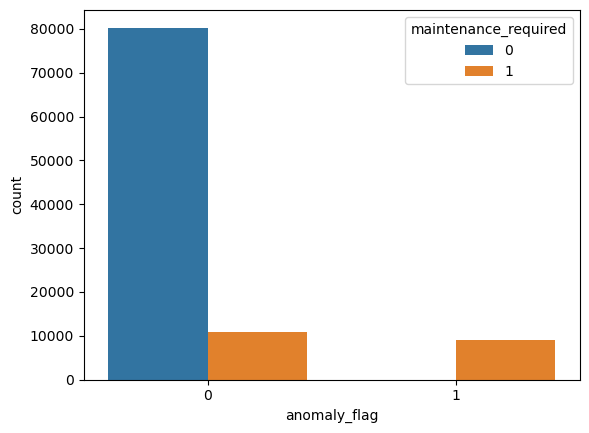

In [11]:
# Check anomaly_flag distribution with target

print(pd.crosstab(data['anomaly_flag'], data['maintenance_required'], normalize='index'))

# Plot

sns.countplot(x='anomaly_flag', hue='maintenance_required', data=data)
plt.show()

Based on distribution in the plot, anomaly_flag 1 almost the same distribution. So it means dataset that has anomaly_flag 1 doesn't have to be done maintenance. This information is reliable for model prediction.

6. Explore column categorical `machine_status`.

maintenance_required         0         1
machine_status                          
0                     0.890784  0.109216
1                     0.893072  0.106928
2                     0.000000  1.000000


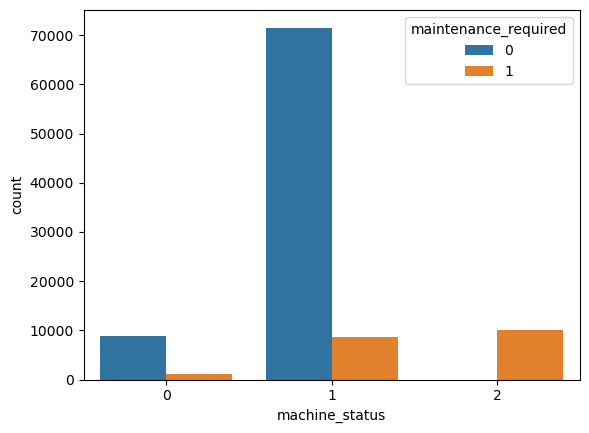

In [12]:
# machine_status distribution with target

print(pd.crosstab(data['machine_status'], data['maintenance_required'], normalize='index'))

# Plot

sns.countplot(x='machine_status', hue='maintenance_required', data=data)
plt.show()

Based on distribution in the plot, the distribution for `machine_status` = 2 only have `maintenance_required` = 1. This is really clear that equipment have failure status need maintenance. if status 2 target always 1. This information is quite complicated, when doing inference that is unusual to predict failure equipment. This issue will analyze further in Feature Engineering.

7. Top 5 equipments those have total `maintenance_required` = 1.

In [13]:
# Group by machine_id (maintenance_required = 1)
top_5_machines = (
    data[data['maintenance_required'] == 1]
    .groupby('machine_id')
    .size()
    .sort_values(ascending=False)
    .head()
)

top_5_machines

machine_id
30    433
5     428
29    427
32    426
45    424
dtype: int64

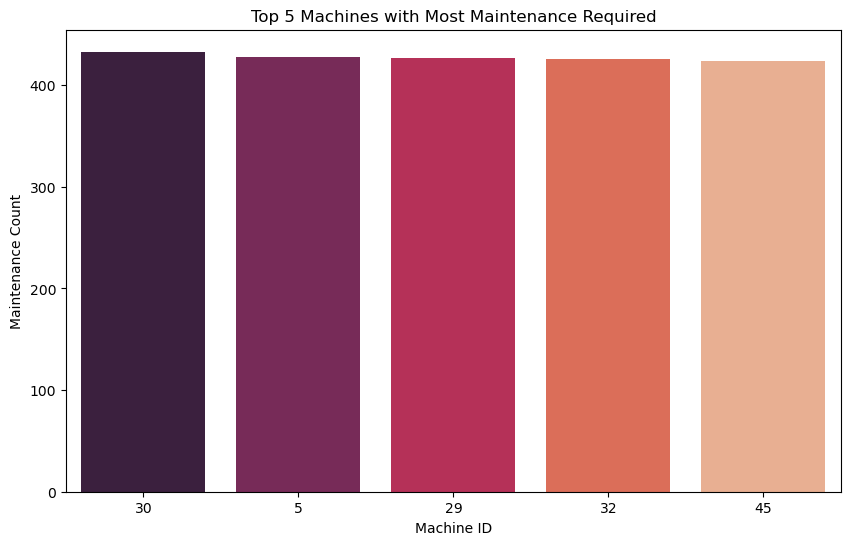

In [14]:
# Create plot

plt.figure(figsize=(10,6))
sns.barplot(
    x=top_5_machines.index.astype(str),
    y=top_5_machines.values,
    hue=top_5_machines.index.astype(str),
    palette='rocket',
    legend=False
)
plt.title('Top 5 Machines with Most Maintenance Required')
plt.xlabel('Machine ID')
plt.ylabel('Maintenance Count')
plt.show()

From the result analysis, top equipment that have many maintenance_required = 1 are number 30 and following 5, 29, 32 and 45. Based on this result we can focus for predictive maintenance esspecialy to equipments with many maintenance_required lebel. So it is easier for the maintenance and production teams to schedule and prioritize the maintenance activity.

8. Bottom 5 equipments those have total `maintenance_required` = 1.

In [15]:
# Group by machine_id (maintenance_required = 1)
bottom_5_machines = (
    data[data['maintenance_required'] == 1]
    .groupby('machine_id')
    .size()
    .sort_values(ascending=True) # Checking the bottom in head position
    .head()
)

bottom_5_machines

machine_id
41    348
19    358
11    362
20    364
37    364
dtype: int64

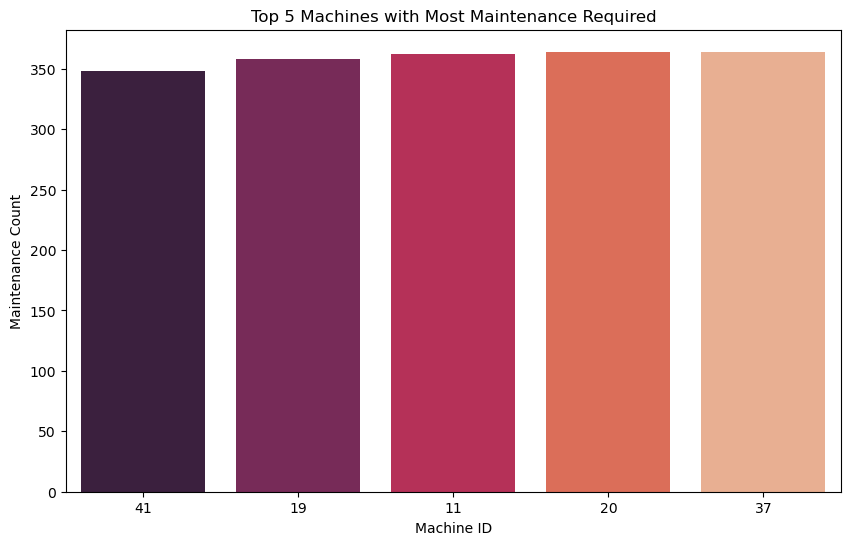

In [16]:
# Create plot

plt.figure(figsize=(10,6))
sns.barplot(
    x=bottom_5_machines.index.astype(str),
    y=bottom_5_machines.values,
    hue=bottom_5_machines.index.astype(str),
    palette='rocket',
    legend=False
)
plt.title('Top 5 Machines with Most Maintenance Required')
plt.xlabel('Machine ID')
plt.ylabel('Maintenance Count')
plt.show()

From the result analysis, bottom equipment that have many maintenance_required = 1 are number 41 and following 19, 11, 20 and 37. It means those equipment slightly stable in term of operation since have less maintenance_required = 1. Based on this result we can treat all more stable equipment as benchmark to do maintenance and setting opertaion for others equipment. So can increase the performance of the equipment.

# V. Feature Engineering

1. Handling Cardinality

In [17]:
# Checking unique value for categorical columns

pd.set_option('display.max_colwidth', None)

cat_cols = ['timestamp','machine_id', 'machine_status', 'anomaly_flag', 'failure_type']

listItem = []
for col in cat_cols:
  listItem.append([col, data[col].nunique(), data[col].unique()])

pd.DataFrame(columns=['column', 'unique value count', 'unique value'], data=listItem)

,column,unique value count,unique value
0,timestamp,100000,"[2025-01-01 00:00:00, 2025-01-01 00:01:00, 2025-01-01 00:02:00, 2025-01-01 00:03:00, 2025-01-01 00:04:00, 2025-01-01 00:05:00, 2025-01-01 00:06:00, 2025-01-01 00:07:00, 2025-01-01 00:08:00, 2025-01-01 00:09:00, 2025-01-01 00:10:00, 2025-01-01 00:11:00, 2025-01-01 00:12:00, 2025-01-01 00:13:00, 2025-01-01 00:14:00, 2025-01-01 00:15:00, 2025-01-01 00:16:00, 2025-01-01 00:17:00, 2025-01-01 00:18:00, 2025-01-01 00:19:00, 2025-01-01 00:20:00, 2025-01-01 00:21:00, 2025-01-01 00:22:00, 2025-01-01 00:23:00, 2025-01-01 00:24:00, 2025-01-01 00:25:00, 2025-01-01 00:26:00, 2025-01-01 00:27:00, 2025-01-01 00:28:00, 2025-01-01 00:29:00, 2025-01-01 00:30:00, 2025-01-01 00:31:00, 2025-01-01 00:32:00, 2025-01-01 00:33:00, 2025-01-01 00:34:00, 2025-01-01 00:35:00, 2025-01-01 00:36:00, 2025-01-01 00:37:00, 2025-01-01 00:38:00, 2025-01-01 00:39:00, 2025-01-01 00:40:00, 2025-01-01 00:41:00, 2025-01-01 00:42:00, 2025-01-01 00:43:00, 2025-01-01 00:44:00, 2025-01-01 00:45:00, 2025-01-01 00:46:00, 2025-01-01 00:47:00, 2025-01-01 00:48:00, 2025-01-01 00:49:00, 2025-01-01 00:50:00, 2025-01-01 00:51:00, 2025-01-01 00:52:00, 2025-01-01 00:53:00, 2025-01-01 00:54:00, 2025-01-01 00:55:00, 2025-01-01 00:56:00, 2025-01-01 00:57:00, 2025-01-01 00:58:00, 2025-01-01 00:59:00, 2025-01-01 01:00:00, 2025-01-01 01:01:00, 2025-01-01 01:02:00, 2025-01-01 01:03:00, 2025-01-01 01:04:00, 2025-01-01 01:05:00, 2025-01-01 01:06:00, 2025-01-01 01:07:00, 2025-01-01 01:08:00, 2025-01-01 01:09:00, 2025-01-01 01:10:00, 2025-01-01 01:11:00, 2025-01-01 01:12:00, 2025-01-01 01:13:00, 2025-01-01 01:14:00, 2025-01-01 01:15:00, 2025-01-01 01:16:00, 2025-01-01 01:17:00, 2025-01-01 01:18:00, 2025-01-01 01:19:00, 2025-01-01 01:20:00, 2025-01-01 01:21:00, 2025-01-01 01:22:00, 2025-01-01 01:23:00, 2025-01-01 01:24:00, 2025-01-01 01:25:00, 2025-01-01 01:26:00, 2025-01-01 01:27:00, 2025-01-01 01:28:00, 2025-01-01 01:29:00, 2025-01-01 01:30:00, 2025-01-01 01:31:00, 2025-01-01 01:32:00, 2025-01-01 01:33:00, 2025-01-01 01:34:00, 2025-01-01 01:35:00, 2025-01-01 01:36:00, 2025-01-01 01:37:00, 2025-01-01 01:38:00, 2025-01-01 01:39:00, ...]"
1,machine_id,50,"[39, 29, 15, 43, 8, 21, 19, 23, 11, 24, 36, 40, 3, 22, 2, 44, 30, 38, 33, 12, 25, 49, 27, 42, 28, 16, 47, 37, 7, 9, 18, 4, 14, 50, 26, 20, 35, 17, 6, 34, 10, 31, 48, 45, 41, 1, 5, 13, 32, 46]"
2,machine_status,3,"[1, 2, 0]"
3,anomaly_flag,2,"[0, 1]"
4,failure_type,5,"[Normal, Vibration Issue, Overheating, Pressure Drop, Electrical Fault]"


From the result, columns `machine_status`, `anomaly_flag` and `failure_type` have low cardinality, for column `machine_id` has medium level of cardinality. Column `timestamp` has high cardinality because it has 100000 unique value. `timestamp` unique value is different for every data, it is like the ID of time of data. With consideration this column only id/date data when the data was being recorded. Because data have nothing to do with the equipment condition, droping this data is solution to make modeling easier. Also high cardinality can cause model overfitting.

In [18]:
# Save timestamp column

timestamp = data['timestamp']

# Drop kolom timestamp

data_dropped = data.drop(columns=['timestamp'], axis=1)

data_dropped

,machine_id,temperature,vibration,humidity,pressure,energy_consumption,machine_status,anomaly_flag,predicted_remaining_life,failure_type,downtime_risk,maintenance_required
0,39,78.61,28.65,79.96,3.73,2.16,1,0,106,Normal,0.0,0
1,29,68.19,57.28,35.94,3.64,0.69,1,0,320,Normal,0.0,0
2,15,98.94,50.20,72.06,1.00,2.49,1,1,19,Normal,1.0,1
3,43,90.91,37.65,30.34,3.15,4.96,1,1,10,Normal,1.0,1
4,8,72.32,40.69,56.71,2.68,0.63,2,0,65,Vibration Issue,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
99995,3,71.47,54.34,46.72,1.83,3.05,1,0,313,Normal,0.0,0
99996,23,87.23,34.99,33.84,4.67,4.47,1,0,439,Normal,0.0,0
99997,10,93.01,51.79,64.28,4.04,3.62,1,1,30,Normal,1.0,1
99998,47,84.41,22.35,35.18,2.88,2.37,1,0,487,Normal,0.0,0


`timestamp` column has been dropped.

2. Feature Creation

From EDA, the result of distribution column categorical `machine_status` is not balance in machine status = 2 that only has target = 1 data and no 0. It means equipment with status 2/failure always need maintenance no matter what condition of equipment. In this part we will create new feature by changing `machine_status` feature. Original feature is 0 = Idle, 1 = Running, 2 = Failure. With considertaion will engineer this feature by grouping into two category 1 = Running and 0 = Not Running (Idle/Failure). This creation will still informative since during production running equipment is the most important, and not running equipment is between idle/failure. It is unusual also to predict maintenance_required for machine that clearly failure. This is also beacuse of the relevance prediction and reduce feature complexity.

In [19]:
# Save old machine_status column

machine_status_old = data['machine_status']

# Create new machine_status data by changing the value in the old one.

data_dropped['machine_status'] = data_dropped['machine_status'].apply(lambda x: 1 if x == 1 else 0)
data_dropped['machine_status'] = data_dropped['machine_status'].apply(lambda x: 1 if x == 1 else 0)
data_dropped.machine_status.unique()

array([1, 0])

New `machine_status` feature has been created.

3. Split Between X (Features) and Y (Target)

In [20]:
# Split Between X (Features) and Y (Target)

X = data_dropped.drop(['maintenance_required'], axis = 1)
y = data_dropped['maintenance_required']
X

,machine_id,temperature,vibration,humidity,pressure,energy_consumption,machine_status,anomaly_flag,predicted_remaining_life,failure_type,downtime_risk
0,39,78.61,28.65,79.96,3.73,2.16,1,0,106,Normal,0.0
1,29,68.19,57.28,35.94,3.64,0.69,1,0,320,Normal,0.0
2,15,98.94,50.20,72.06,1.00,2.49,1,1,19,Normal,1.0
3,43,90.91,37.65,30.34,3.15,4.96,1,1,10,Normal,1.0
4,8,72.32,40.69,56.71,2.68,0.63,0,0,65,Vibration Issue,0.0
...,...,...,...,...,...,...,...,...,...,...,...
99995,3,71.47,54.34,46.72,1.83,3.05,1,0,313,Normal,0.0
99996,23,87.23,34.99,33.84,4.67,4.47,1,0,439,Normal,0.0
99997,10,93.01,51.79,64.28,4.04,3.62,1,1,30,Normal,1.0
99998,47,84.41,22.35,35.18,2.88,2.37,1,0,487,Normal,0.0


In [21]:
y

0        0
1        0
2        1
3        1
4        1
        ..
99995    0
99996    0
99997    1
99998    0
99999    0
Name: maintenance_required, Length: 100000, dtype: int64

Features and Traget have been split.

4. Splitting between Train Set and Test Set

In [22]:
# Splitting between Train Set and Test Set

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 8)
print('Train Size', X_train.shape)
print('Test Size', X_test.shape)

Train Size (80000, 11)
Test Size (20000, 11)


In [23]:
X_train

,machine_id,temperature,vibration,humidity,pressure,energy_consumption,machine_status,anomaly_flag,predicted_remaining_life,failure_type,downtime_risk
61552,32,80.69,61.83,71.84,1.26,1.05,1,0,458,Normal,0.0
84752,22,62.21,42.44,78.43,2.94,2.95,1,0,450,Normal,0.0
65652,31,65.02,39.76,56.48,4.06,1.11,1,0,285,Normal,0.0
23453,43,73.85,44.82,39.98,2.03,4.31,1,0,191,Normal,0.0
80360,38,78.52,29.25,50.43,3.21,1.84,1,0,403,Normal,0.0
...,...,...,...,...,...,...,...,...,...,...,...
10376,14,73.82,65.33,55.09,2.44,2.63,1,0,247,Normal,0.0
62426,24,58.94,58.52,64.04,4.17,0.84,1,0,388,Normal,0.0
18417,13,88.13,70.62,77.62,1.26,4.39,1,0,399,Normal,0.0
25940,19,78.56,55.01,79.67,3.77,3.69,1,0,272,Normal,0.0


Train and test have been split.

5. Handling Outliers

In [24]:
# Check distribution form skewness

num_cols = ['temperature', 'vibration', 'humidity', 'pressure', 'energy_consumption', 'predicted_remaining_life', 'downtime_risk']

listItem= []

for col in num_cols:
  listItem.append([col, round(X_train[col].skew(),1), np.where(
    (round(X_train[col].skew(),1) <= 0.5) & (round(X_train[col].skew(),1) >= -0.5),
    'normal',
    'skewed')])



skewness = pd.DataFrame(columns=['column', 'skewness value', 'distribution'], data= listItem)
skewness

,column,skewness value,distribution
0,temperature,-0.0,normal
1,vibration,0.0,normal
2,humidity,0.0,normal
3,pressure,0.0,normal
4,energy_consumption,0.0,normal
5,predicted_remaining_life,0.1,normal
6,downtime_risk,2.9,skewed


From skewness checking, all columns is normal except for column `downtime_risk` that is skewed with skweness 2.9. Oultiers will be chceked further.

In [25]:
# Get upper, lower boundaries and percentage of outliers

column = []
lower_bound = []
upper_bound = []
percent_total_outlier = []

for row in range (0, len(skewness)):
  col = skewness['column'][row]
  #checking upper and lower boundary
  if skewness['distribution'][row] == 'skewed':
    IQR = X_train[col].quantile(0.75) - X_train[col].quantile(0.25)
    lower_boundary = X_train[col].quantile(0.25) - (IQR * 3)
    upper_boundary = X_train[col].quantile(0.75) + (IQR * 3)
  else:
    lower_boundary = X_train[col].mean() - 3* X_train[col].std()
    upper_boundary = X_train[col].mean() + 3* X_train[col].std()
  #append to list
  column.append(col)
  lower_bound.append(lower_boundary)
  upper_bound.append(upper_boundary)
  totout = ((len(X_train[X_train[col] > upper_boundary]) / len(X_train) * 100) + (len(X_train[X_train[col] < lower_boundary]) / len(X_train) * 100))
  percent_total_outlier.append(totout)

outliers = pd.DataFrame({
    'column': column,
    #round the value
    'upper_boundary': [round(upper_bound,2) for upper_bound in upper_bound],
    'lower_boundary': [round(lower_bound,2) for lower_bound in lower_bound],
    'percentage_total_outlier': [round(percent_total_outlier,2) for percent_total_outlier in percent_total_outlier]
})
outliers

,column,upper_boundary,lower_boundary,percentage_total_outlier
0,temperature,105.13,44.89,0.30
1,vibration,94.98,5.05,0.26
2,humidity,98.29,11.73,0.00
3,pressure,6.46,-0.46,0.00
4,energy_consumption,6.64,-1.15,0.00
5,predicted_remaining_life,684.25,-216.65,0.00
6,downtime_risk,0.00,0.00,8.95


From the result, all columns have very low percentage of outlier except for column `downtime_risk` that has 8.95% outliers. This is consider high, further analysis needed.

In [26]:
# Checking unique value for downtime_risk

X_train.downtime_risk.unique()

array([0.  , 1.  , 0.97, 0.92, 0.93, 0.98, 0.99, 0.88])

`downtime_ris`k is the data score that has range from 0 until 1. Based on the unique value theres no value that outside range of 0 to 1. With consideration column will be kept for modeling because the value can give information to model and also outilers consider natural that is normal for every equipment and evrytime the condition and score different.

6. Handling Missing Value

In [27]:
# Cek X_train null

X_train.isnull().sum()

machine_id                  0
temperature                 0
vibration                   0
humidity                    0
pressure                    0
energy_consumption          0
machine_status              0
anomaly_flag                0
predicted_remaining_life    0
failure_type                0
downtime_risk               0
dtype: int64

From Data Loading, there is no missing value. In this step just to make sure before modeling. Based on result there is no missing value in every features.

7. Split Between Numeric Columns and Categorical Columns

In [28]:
# Get numeric and categorical column

num_columns = ['temperature', 'vibration', 'humidity', 'pressure', 'energy_consumption', 'predicted_remaining_life',  'downtime_risk']

cat_columns = ['machine_id', 'machine_status', 'anomaly_flag', 'failure_type']

print('Numeric Columns : ', num_columns)
print('Categorical Columns : ', cat_columns)

Numeric Columns :  ['temperature', 'vibration', 'humidity', 'pressure', 'energy_consumption', 'predicted_remaining_life', 'downtime_risk']
Categorical Columns :  ['machine_id', 'machine_status', 'anomaly_flag', 'failure_type']


In [29]:
# Split numerical and categorical columns

X_train_num = X_train[num_columns]
X_test_num = X_test[num_columns]

X_train_cat = X_train[cat_columns]
X_test_cat = X_test[cat_columns]

X_train_num

,temperature,vibration,humidity,pressure,energy_consumption,predicted_remaining_life,downtime_risk
61552,80.69,61.83,71.84,1.26,1.05,458,0.0
84752,62.21,42.44,78.43,2.94,2.95,450,0.0
65652,65.02,39.76,56.48,4.06,1.11,285,0.0
23453,73.85,44.82,39.98,2.03,4.31,191,0.0
80360,78.52,29.25,50.43,3.21,1.84,403,0.0
...,...,...,...,...,...,...,...
10376,73.82,65.33,55.09,2.44,2.63,247,0.0
62426,58.94,58.52,64.04,4.17,0.84,388,0.0
18417,88.13,70.62,77.62,1.26,4.39,399,0.0
25940,78.56,55.01,79.67,3.77,3.69,272,0.0


In [30]:
X_train_cat

,machine_id,machine_status,anomaly_flag,failure_type
61552,32,1,0,Normal
84752,22,1,0,Normal
65652,31,1,0,Normal
23453,43,1,0,Normal
80360,38,1,0,Normal
...,...,...,...,...
10376,14,1,0,Normal
62426,24,1,0,Normal
18417,13,1,0,Normal
25940,19,1,0,Normal


Numeric Columns and Categorical Columns have been split.

8. Feature Selection

Selecting features need to do by correlation test. For columns Numerical that has target Categorical will use Kendall.

In [31]:
# Feature selection Numerical columns

p_values = []
interpretation = []
cols = []

for col in X_train_num.columns:
    corr_coef, p_value = kendalltau(X_train_num[col], y_train)
    
    p_values.append(p_value)
    cols.append(col)
    
    if p_value < 0.05:
        interpretation.append('has correlation')
    else:
        interpretation.append('no correlation')

# Data frame

pd.DataFrame({
    'column': cols,
    'p_value': p_values,
    'result': interpretation
})

,column,p_value,result
0,temperature,0.000000e+00,has correlation
1,vibration,9.365834e-117,has correlation
2,humidity,9.303971e-01,no correlation
3,pressure,1.094357e-01,no correlation
4,energy_consumption,6.169104e-01,no correlation
5,predicted_remaining_life,0.000000e+00,has correlation
6,downtime_risk,0.000000e+00,has correlation


Based on the result columns `humidity`, `pressure` and `energy_conumption` have no correlation or weak correlation with target. With consideration all those three column will still be kept for modeling because those columns is equipmnet condition that actually important in real case, also very good for further study in analysis model to still keep those faetures

For columns Categorical that has target Categorical will use chi-squered.

In [32]:
# Feature selection Categorical columns

p_values = []
interpretation = []
cols = []

for col in X_train_cat.columns:
    contingency_table = pd.crosstab(X_train_cat[col], y_train)
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
    
    p_values.append(p_value)
    cols.append(col)
    
    if p_value < 0.05:
        interpretation.append('has correlation')
    else:
        interpretation.append('no correlation')


# Data frame

pd.DataFrame({
    'column': cols,
    'p_value': p_values,
    'result': interpretation
})

,column,p_value,result
0,machine_id,0.386829,no correlation
1,machine_status,0.000000,has correlation
2,anomaly_flag,0.000000,has correlation
3,failure_type,0.000000,has correlation


Based on the result, only column `machine_id` that has no correlation with target, this feature is only label for the machine, there is no also lebel that indicate that all the equipment is different because the lebel is numeric, asuming all 50 equipment is the same. With consideration `machine_id` will be dropped.

In [33]:
# Drop machine_id from data train and test

X_train_feature = X_train.drop(['machine_id'], axis=1)

X_test_feature = X_test.drop(['machine_id'], axis=1)

X_train_feature

,temperature,vibration,humidity,pressure,energy_consumption,machine_status,anomaly_flag,predicted_remaining_life,failure_type,downtime_risk
61552,80.69,61.83,71.84,1.26,1.05,1,0,458,Normal,0.0
84752,62.21,42.44,78.43,2.94,2.95,1,0,450,Normal,0.0
65652,65.02,39.76,56.48,4.06,1.11,1,0,285,Normal,0.0
23453,73.85,44.82,39.98,2.03,4.31,1,0,191,Normal,0.0
80360,78.52,29.25,50.43,3.21,1.84,1,0,403,Normal,0.0
...,...,...,...,...,...,...,...,...,...,...
10376,73.82,65.33,55.09,2.44,2.63,1,0,247,Normal,0.0
62426,58.94,58.52,64.04,4.17,0.84,1,0,388,Normal,0.0
18417,88.13,70.62,77.62,1.26,4.39,1,0,399,Normal,0.0
25940,78.56,55.01,79.67,3.77,3.69,1,0,272,Normal,0.0


`machine_id` column has been dropped.

9. Column Transformer

In [34]:
# Select columns need to do scaling and encoding

num_cols_scaling = ['temperature', 'vibration', 'humidity', 'pressure', 'energy_consumption', 'predicted_remaining_life', 'downtime_risk'] # All coumns numerical
cat_cols_encoding = ['failure_type'] # Only categorical column with string data type

Using `StandardScaler` for scaling. Using `OneHotEncoder` for encoding because column is not ordinal.

In [35]:
# Making column transformer for preprocessing

transformer = ColumnTransformer([
('scaler', StandardScaler(), num_cols_scaling),
('encoding', OneHotEncoder(handle_unknown='ignore'), cat_cols_encoding)
], remainder='passthrough', # Remainder is for categorical columns which no need to do encoding
force_int_remainder_cols=False
)

Column Transformer for modeling is completed.

# VI. Modeling

1. Model Definition

Using 5 model to check which one is the best model.

In [36]:
# Pipeline for KNN

pipe_knn = Pipeline([
    ('transformer', transformer),
    ('classifier', KNeighborsClassifier())
])

# Pipeline for SVM

pipe_svm = Pipeline([
    ('transformer', transformer),
    ('classifier', SVC())
])

# Pipeline for Decision Tree

pipe_dt = Pipeline([
    ('transformer', transformer),
    ('classifier', DecisionTreeClassifier())
])

# Pipeline for Random Forest

pipe_rf = Pipeline([
    ('transformer', transformer),
    ('classifier', RandomForestClassifier())
])

# Pipeline for XGBoost

pipe_xgb = Pipeline([
    ('transformer', transformer),
    ('classifier', XGBClassifier())
])

Model definition with Pipeline is completed

2. Model Training

In [37]:
# Pipeline for KNN

pipe_knn.fit(X_train_feature, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('scaler', StandardScaler(),
                                                  ['temperature', 'vibration',
                                                   'humidity', 'pressure',
                                                   'energy_consumption',
                                                   'predicted_remaining_life',
                                                   'downtime_risk']),
                                                 ('encoding',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['failure_type'])])),
                ('classifier', KNeighborsClassifier())])

In [38]:
# Pipeline for SVM

pipe_svm.fit(X_train_feature, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('scaler', StandardScaler(),
                                                  ['temperature', 'vibration',
                                                   'humidity', 'pressure',
                                                   'energy_consumption',
                                                   'predicted_remaining_life',
                                                   'downtime_risk']),
                                                 ('encoding',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['failure_type'])])),
                ('classifier', SVC())])

In [39]:
# Pipeline for Decision Tree

pipe_dt.fit(X_train_feature, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('scaler', StandardScaler(),
                                                  ['temperature', 'vibration',
                                                   'humidity', 'pressure',
                                                   'energy_consumption',
                                                   'predicted_remaining_life',
                                                   'downtime_risk']),
                                                 ('encoding',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['failure_type'])])),
                ('classifier', DecisionTreeClassifier())])

In [40]:
# Pipeline for Random Forest

pipe_rf.fit(X_train_feature, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('scaler', StandardScaler(),
                                                  ['temperature', 'vibration',
                                                   'humidity', 'pressure',
                                                   'energy_consumption',
                                                   'predicted_remaining_life',
                                                   'downtime_risk']),
                                                 ('encoding',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['failure_type'])])),
                ('classifier', RandomForestClassifier())])

In [41]:
# Pipeline for XGBoost

pipe_xgb.fit(X_train_feature, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('scaler', StandardScaler(),
                                                  ['temperature', 'vibration',
                                                   'humidity', 'pressure',
                                                   'energy_consumption',
                                                   'predicted_remaining_life',
                                                   'downtime_risk']),
                                                 ('encoding',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['failure_type'])])),
                ('classifier',
                 XGBC...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, ...))])

Model Training is completed. In this modeling prediction, where the goal is to detect faulty or defective machine conditions and know `maintenance_required` prediction, In the context of smart manufacturing, minimizing `false negatives (FN)` is critical. A false negative occurs when a defective machine (1) is incorrectly classified as normal (0), allowing it to continue operating. This can lead to severe consequences such as product defects, machinery breakdown, reduced production efficiency, and even safety hazards. These risks often have a far greater cost than `false positives (FP)`, which might only lead to temporary halts or unnecessary maintenance checks, which is consider less risk in term of business and safety. Therefore, the focus should be on improving the model `Recall` as important metric evaluation, which measures its ability to correctly identify all actual faulty cases. By maximizing recall, it ensures that as few faulty machines as possible are missed by the system. This approach prioritizes safety, quality control, and operational continuity in manufacturing environment.

3. Cross Validation

Before evaluation, all model will be checked the cross validation with 5 fold for metric `Recall`. This validation is to check the consistency of the model

In [42]:
# Cross Validation for KNN

recall_train_cross_val = cross_val_score(pipe_knn,
                                     X_train_feature,
                                     y_train,
                                     cv=5,
                                     scoring="recall")

print('Recall Score - All - Cross Validation  : ', recall_train_cross_val)
print('Recall Score - Mean - Cross Validation : ', recall_train_cross_val.mean())
print('Recall Score - Std - Cross Validation  : ', recall_train_cross_val.std())
print('Recall Score - Range of Test-Set       : ', (recall_train_cross_val.mean()-recall_train_cross_val.std()) , '-', (recall_train_cross_val.mean()+recall_train_cross_val.std()))

Recall Score - All - Cross Validation  :  [0.83069119 0.83576411 0.8208624  0.84432467 0.83703234]
Recall Score - Mean - Cross Validation :  0.8337349397590362
Recall Score - Std - Cross Validation  :  0.007773023826158857
Recall Score - Range of Test-Set       :  0.8259619159328774 - 0.8415079635851951


In [43]:
# Cross Validation for SVM

recall_train_cross_val = cross_val_score(pipe_svm,
                                     X_train_feature,
                                     y_train,
                                     cv=5,
                                     scoring="recall")

print('Recall Score - All - Cross Validation  : ', recall_train_cross_val)
print('Recall Score - Mean - Cross Validation : ', recall_train_cross_val.mean())
print('Recall Score - Std - Cross Validation  : ', recall_train_cross_val.std())
print('Recall Score - Range of Test-Set       : ', (recall_train_cross_val.mean()-recall_train_cross_val.std()) , '-', (recall_train_cross_val.mean()+recall_train_cross_val.std()))

Recall Score - All - Cross Validation  :  [0.8230818  0.82974001 0.81325301 0.8373494  0.82942295]
Recall Score - Mean - Cross Validation :  0.826569435637286
Recall Score - Std - Cross Validation  :  0.00804852091362313
Recall Score - Range of Test-Set       :  0.8185209147236628 - 0.8346179565509092


In [44]:
# Cross Validation for Decision Tree

recall_train_cross_val = cross_val_score(pipe_dt,
                                     X_train_feature,
                                     y_train,
                                     cv=5,
                                     scoring="recall")

print('Recall Score - All - Cross Validation  : ', recall_train_cross_val)
print('Recall Score - Mean - Cross Validation : ', recall_train_cross_val.mean())
print('Recall Score - Std - Cross Validation  : ', recall_train_cross_val.std())
print('Recall Score - Range of Test-Set       : ', (recall_train_cross_val.mean()-recall_train_cross_val.std()) , '-', (recall_train_cross_val.mean()+recall_train_cross_val.std()))

Recall Score - All - Cross Validation  :  [0.92771084 0.92517438 0.92263792 0.93563729 0.92707673]
Recall Score - Mean - Cross Validation :  0.9276474318325935
Recall Score - Std - Cross Validation  :  0.004367577769872542
Recall Score - Range of Test-Set       :  0.923279854062721 - 0.932015009602466


In [45]:
#Cross Validation for Random Forest

recall_train_cross_val = cross_val_score(pipe_rf,
                                     X_train_feature,
                                     y_train,
                                     cv=5,
                                     scoring="recall")

print('Recall Score - All - Cross Validation  : ', recall_train_cross_val)
print('Recall Score - Mean - Cross Validation : ', recall_train_cross_val.mean())
print('Recall Score - Std - Cross Validation  : ', recall_train_cross_val.std())
print('Recall Score - Range of Test-Set       : ', (recall_train_cross_val.mean()-recall_train_cross_val.std()) , '-', (recall_train_cross_val.mean()+recall_train_cross_val.std()))

Recall Score - All - Cross Validation  :  [0.90805327 0.91122384 0.90710209 0.92010146 0.91249207]
Recall Score - Mean - Cross Validation :  0.9117945466074826
Recall Score - Std - Cross Validation  :  0.0046007247044304285
Recall Score - Range of Test-Set       :  0.9071938219030522 - 0.916395271311913


In [46]:
# Cross Validation for XGBoost

recall_train_cross_val = cross_val_score(pipe_xgb,
                                     X_train_feature,
                                     y_train,
                                     cv=5,
                                     scoring="recall")

print('Recall Score - All - Cross Validation  : ', recall_train_cross_val)
print('Recall Score - Mean - Cross Validation : ', recall_train_cross_val.mean())
print('Recall Score - Std - Cross Validation  : ', recall_train_cross_val.std())
print('Recall Score - Range of Test-Set       : ', (recall_train_cross_val.mean()-recall_train_cross_val.std()) , '-', (recall_train_cross_val.mean()+recall_train_cross_val.std()))

Recall Score - All - Cross Validation  :  [0.90837032 0.91407736 0.90963855 0.92168675 0.91439442]
Recall Score - Mean - Cross Validation :  0.9136334812935955
Recall Score - Std - Cross Validation  :  0.004675284360473506
Recall Score - Range of Test-Set       :  0.908958196933122 - 0.9183087656540689


- `KNN` model achieved an average recall of 0.8337 across all folds with a standard deviation of 0.0078, indicating relatively stable performance, although the recall is slightly lower compared to other models.
- `SVM` model recorded an average recall of 0.8266, with a slightly higher variation std: 0.0080 than KNN, and has the lowest recall score.
- `Decision Tree` model achieved the highest recall score of 0.9282 with a low standard deviation of 0.0046, indicating strong and consistent recall performance, it is highest recall among all models.
- `Random Forest` model demonstrated a strong average recall of 0.9119, with low variability (std: 0.0044), suggesting it performs consistently well in identifying positive cases.
- `XGBoost` delivered an average recall of 0.9136, with a standard deviation of 0.0047, showing reliable and slightly better recall than Random Forest, making it one of the top-performing models in terms of balance between recall and consistency.

All the model in baseline condition has good consisitency with 5 fold cross validation with low std. That proof model can identify data with various recall score, the high recall score is model Decision Tree and following XGBoost and Random Forest with score more than 0.9 which is good score for modeling.

4. Model Evaluation

Model Evalution is to evaluate all the models and compare the performance score (Recall) in training and set, in this section include f1 score just for secondary metrics if needed.

In [47]:
# List of Pipeline and Model

models = {
    'KNN': pipe_knn,
    'SVM': pipe_svm,
    'Decision Tree': pipe_dt,
    'Random Forest': pipe_rf,
    'XGBoost': pipe_xgb
}

results = []

for name, model in models.items():

    # Predict on train and test

    y_train_pred = model.predict(X_train_feature)
    y_test_pred = model.predict(X_test_feature)

    # Metric train

    train_rec = recall_score(y_train, y_train_pred, zero_division=0)
    train_f1 = f1_score(y_train, y_train_pred, zero_division=0)

    # Metric test
    
    test_rec = recall_score(y_test, y_test_pred, zero_division=0)
    test_f1 = f1_score(y_test, y_test_pred, zero_division=0)

    results.append({
        "Model": name,
        "Train Recall": train_rec,
        "Test Recall": test_rec,
        "Train F1 Score": train_f1,
        "Test F1 Score": test_f1
    })

df_results = pd.DataFrame(results)
print(df_results)

           Model  Train Recall  Test Recall  Train F1 Score  Test F1 Score
0            KNN      0.852758     0.827349        0.915640       0.893564
1            SVM      0.826569     0.821238        0.905051       0.901846
2  Decision Tree      1.000000     0.926916        1.000000       0.922804
3  Random Forest      0.999937     0.909346        0.999968       0.952267
4        XGBoost      0.943247     0.910109        0.970731       0.950027


- `KNN` and `SVM` have lower recall values, with SVM performing the weakest in identifying positive cases. This two model are simple model which is also not suitable for large data like this case. KNN also not learing really well or lazy learning, and SVM has very long running time with bad result.
- `Decision Tree` achieved perfect recall on the train set and the highest recall on the test set, indicating it captures almost all positive cases but may risk overfitting, because in test drop from 1 to 0.92 (0.08 difference). It means model can learn perfectly in train but not in test.
- `Random Forest` also achieved perfect train set, but drop to 0.909 (around 0.09 difference). It means model can learn perfectly in train but not in test. Random forest is ensemble of many decision tree, it using bagging method and more generelized the data, it should be more stable than Decision Tree, looking at F1 score. Random forest has better performance than Decision Tree.
- `XGBoost` demonstrated high recall on both training and test data, balancing accuracy and generalization effectively. The diffrence from train and test only 0.03 and also in F1 score. It makes this model is good fit, because it build the tree sequentially and fix error (boosting), this model also more accurate, handling inbalance data well and more generelized the data.
- Considering the good fit, more stable and suitable recall score, XGBoost is considerd as most suitable and reliable model for this case.

# VII. Model Optimization

For optimization, will conduct hyperparameter tuning using `RandomizedSearchCV` of the most reliable model which is XGBoost.

In [48]:
# Define parameter grid

param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [3, 5, 7],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__subsample': [0.6, 0.8, 1.0],
    'classifier__colsample_bytree': [0.6, 0.8, 1.0],
    'classifier__gamma': [0, 0.1, 0.3],
    'classifier__reg_alpha': [0, 0.1, 1],
    'classifier__reg_lambda': [1, 2, 3]
} # Every parameter have 3 trial value 

# Setup RandomizedSearchCV

tuning_xgb = RandomizedSearchCV(
    estimator=pipe_xgb,
    param_distributions=param_grid,
    scoring='recall',
    cv=5,
    random_state=8,
    n_jobs=-1
)

# Train tunning

tuning_xgb.fit(X_train_feature, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('transformer',
                                              ColumnTransformer(force_int_remainder_cols=False,
                                                                remainder='passthrough',
                                                                transformers=[('scaler',
                                                                               StandardScaler(),
                                                                               ['temperature',
                                                                                'vibration',
                                                                                'humidity',
                                                                                'pressure',
                                                                                'energy_consumption',
                                                                                'predicted_remaining_life',
                                                                                'downtime_risk']),
                                                                              ('encoding',
                                                                               OneHotEncoder(handle_unknown='ignore'),
                                                                               ['fai...
                   param_distributions={'classifier__colsample_bytree': [0.6,
                                                                         0.8,
                                                                         1.0],
                                        'classifier__gamma': [0, 0.1, 0.3],
                                        'classifier__learning_rate': [0.01, 0.1,
                                                                      0.2],
                                        'classifier__max_depth': [3, 5, 7],
                                        'classifier__n_estimators': [100, 200,
                                                                     300],
                                        'classifier__reg_alpha': [0, 0.1, 1],
                                        'classifier__reg_lambda': [1, 2, 3],
                                        'classifier__subsample': [0.6, 0.8,
                                                                  1.0]},
                   random_state=8, scoring='recall')

Model tuning has been trained.

In [49]:
# Summary of the tunning

best_param = tuning_xgb.best_params_
print(best_param)

print('\n')
best_pipe = tuning_xgb.best_estimator_
print(best_pipe)

{'classifier__subsample': 0.6, 'classifier__reg_lambda': 3, 'classifier__reg_alpha': 1, 'classifier__n_estimators': 300, 'classifier__max_depth': 7, 'classifier__learning_rate': 0.2, 'classifier__gamma': 0.3, 'classifier__colsample_bytree': 0.6}


Pipeline(steps=[('transformer',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('scaler', StandardScaler(),
                                                  ['temperature', 'vibration',
                                                   'humidity', 'pressure',
                                                   'energy_consumption',
                                                   'predicted_remaining_life',
                                                   'downtime_risk']),
                                                 ('encoding',
                                                  OneHotEncoder(handle_unknow

Above is the summary for the best model and parameter from tunning. Next is checking model evalution and compare with before tunning.

In [50]:
# Metrics Classification

# Train
y_tuning_pred_train = tuning_xgb.predict(X_train_feature)
print("Classification Report - Train")
print(classification_report(y_train, y_tuning_pred_train))

# Test
y_tuning_pred_test = tuning_xgb.predict(X_test_feature)
print("Classification Report - Test")
print(classification_report(y_test, y_tuning_pred_test))

Classification Report - Train
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     64230
           1       1.00      0.98      0.99     15770

    accuracy                           1.00     80000
   macro avg       1.00      0.99      0.99     80000
weighted avg       1.00      1.00      1.00     80000

Classification Report - Test
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     16073
           1       0.98      0.91      0.95      3927

    accuracy                           0.98     20000
   macro avg       0.98      0.95      0.97     20000
weighted avg       0.98      0.98      0.98     20000



Calssification report for the model after tunning. From the result have imporovement from before tuning and model is good fit. Let's compare the Recall score.

In [51]:
# List of Pipeline and Model

models = {
    'XGBoost': pipe_xgb,
    'XGBoost_tunning': tuning_xgb
}

results = []

for name, model in models.items():

    # Predict on train and test

    y_train_pred = model.predict(X_train_feature)
    y_test_pred = model.predict(X_test_feature)

    # Metric train

    train_rec = recall_score(y_train, y_train_pred, zero_division=0)
    train_f1 = f1_score(y_train, y_train_pred, zero_division=0)

    # Metric test
    
    test_rec = recall_score(y_test, y_test_pred, zero_division=0)
    test_f1 = f1_score(y_test, y_test_pred, zero_division=0)

    results.append({
        "Model": name,
        "Train Recall": train_rec,
        "Test Recall": test_rec,
        "Train F1 Score": train_f1,
        "Test F1 Score": test_f1
    })

df_results = pd.DataFrame(results)
print(df_results)

             Model  Train Recall  Test Recall  Train F1 Score  Test F1 Score
0          XGBoost      0.943247     0.910109        0.970731       0.950027
1  XGBoost_tunning      0.976347     0.911383        0.987969       0.946450


After applying hyperparameter tuning using `RandomizedSearchCV` to the XGBoost model, the training recall increased from 0.943 to 0.976, indicating improved sensitivity to positive cases during training. The test recall also improved slightly, from 0.910 to 0.911, suggesting better generalization and a slightly enhanced ability to correctly identify the positive class in unseen data. This makes the tuned XGBoost model more effective for recall focused tasks in this case, such as minimizing false negatives.

# VIII. Model Saving

Saving the best model that is XGBoost model with hyperparameter tunning.

In [52]:
# Save model

with open('model_best.pkl', 'wb') as file:
    pickle.dump(best_pipe, file)

Model is saved.

# IX. Model Inference

Model Inference conducted in file `notebook_inf.ipynb`

# X. Conclusion and Recommendations

1. EDA

- The maintenance_required target variable is imbalanced, with approximately 80,000 samples labeled 0 and 20,000 labeled 1, which can affect model performance.
- For temperature and vibration show near-normal distributions with slight tails, indicating stable operational conditions with a few outliers.
humidity, pressure, and energy_consumption follow uniform distributions.
- Column predicted_remaining_life is right-skewed but becomes uniform after 100, indicating many machines are near end-of-life while others have long remaining life, for downtime_risk is highly right-skewed, meaning most machines have low risk, but a few are critical.
- The correlation analysis shows that several features have meaningful relationships with the target. downtime_risk has a strong positive correlation, predicted_remaining_life demonstrates a moderate negative correlation, suggesting that machines with shorter remaining life are more likely to need maintenance. For temperature and vibration show as notable positive correlations. On the other hand, features such as humidity, pressure, and energy_consumption exhibit weak or no correlation, indicating limited relevance in predicting maintenance requirements.
- For anomaly_flag = 1 corresponds to high temperature and vibration, confirming its data information, but it is not a strong indicator for maintenance_required since both anomaly=0 and anomaly=1 appear across the target classes.
- For machine_status = 2 always corresponds to maintenance_required = 1, meaning failure status directly implies maintenance. This relationship can cause data leakage if included during training, because the information is really explicit in the features.
- The equipment numbers 30, 5, 29, 32, and 45 have the highest number of maintenance_required = 1 labels. Focusing predictive maintenance efforts on these specific machines will help the maintenance and production teams to better schedule and prioritize their activities, improving overall operational efficiency.
- The equipment with the lowest number of maintenance_required = 1 are numbers 41, 19, 11, 20, and 37. This indicates that these machines are relatively more stable in terms of operation, as they require less maintenance. Based on this finding, these more stable pieces of equipment can be used as benchmarks for maintenance planning and operational settings for other machines, helping to improve overall equipment performance.

2. Model

- In this predictive modeling task, the project emphasizes Recall as the key evaluation metric, because the objective is to detect faulty or defective machine conditions by predicting the maintenance required label. Within the context of smart manufacturing, minimizing false negatives (FN) is critical. A false negative misclassifying a faulty machine (1) as normal (0) an result in significant risks such as product defects, machine damage, production downtime, and safety incidents. These consequences are generally more severe than false positives (FP), which may only trigger precautionary maintenance with minimal cost or disruption.

- Based on the cross-validation recall scores, performance comparisons on training and test sets, and the impact of hyperparameter tuning, it is evident that XGBoost consistently delivers the best balance between high recall, generalization, and stability. While models KNN and SVM showed lower recall and are less suitable, Random Forest and XGBoost outperformed them significantly. Although Decision Tree achieved the highest test recall in the initial evaluation, its perfect training performance combined with a drop in the test set suggests potential overfitting. XGBoost maintained a strong recall with a minimal performance gap between training and test sets. After hyperparameter tuning with RandomizedSearchCV , its training recall improved substantially with a slight gain in test recall, confirming better learning without overfitting. XGBoost (with hyperparameter tuning) is the most suitable and reliable model for this classification task. For recommendation, explore more in hyperparameter tunning to improve performance for example trial more parameter grid with possible good parameter or can by using GridSearchCV for tunning so parameter can be checked every posibility to achive best hyperparameter, just this can take long in running. Also can also try to compare metric evalution like ROC-AUC for comparison to know model performance.

- The Best Model XGBoost (with hyperparameter tuning), sucessfully applied for new data or model inference, model is able to predict weather equipment needs predictive maintenance or not. The prediction also deploy in space of hunggingface as simulation. This deployment can be applied in manufacturing enviroment so Production, Maintenance and Enginnering teams can access and predict the equipment data.